# Imports

In [128]:
from load_data import MnistDataloader
from util.storage import STORAGE_DIR
from util.qol import manage_params
from util.datetime import clock, eta
from util.storage import save, load

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from torch import Tensor
from torch.optim import Optimizer
from torch.nn.utils import clip_grad_norm_
from numpy import ndarray as CPUArray
from typing import Union
from copy import deepcopy

In [129]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32

# Load Data

In [113]:
loader = MnistDataloader(
    f"{STORAGE_DIR}mnist_data/train-images.idx3-ubyte",
    f"{STORAGE_DIR}mnist_data/train-labels.idx1-ubyte",
    f"{STORAGE_DIR}mnist_data/t10k-images.idx3-ubyte",
    f"{STORAGE_DIR}mnist_data/t10k-labels.idx1-ubyte",
)
(train_inp, train_out), (eval_inp, eval_out) = loader.load_data(60000, 10000, resize=(32, 32), rand_rot=True, rand_flip=True, batch_size=128,
                                                                device=DEVICE, dtype=DTYPE)
train_inp.shape, train_out.shape, eval_inp.shape, eval_out.shape

Loaded 60000 records.
Loaded 10000 records.


(torch.Size([60000, 1, 32, 32]),
 torch.Size([60000]),
 torch.Size([10000, 1, 32, 32]),
 torch.Size([10000]))

In [114]:
train_inp.device, train_inp.dtype, train_inp.device, train_out.dtype

(device(type='cuda', index=0),
 torch.float32,
 device(type='cuda', index=0),
 torch.int64)

# View data

In [115]:
def show_image(image: Tensor, title: str = None, size: tuple[int, int] = None, cmap='binary'):
    if size is None:
        size = (360, 360)
    if image.ndim == 3:
        image = image.permute(1, 2, 0)
    elif image == 2:
        pass
    else:
        raise ValueError(f"Unsupported ndim")
    image = image.cpu()
    fig, axes = plt.subplots(1, 1, figsize=(size[0]*0.01, size[1]*0.01))
    axes.imshow(image, cmap=cmap)
    if title is not None:
        axes.set_title(title)
    plt.show()

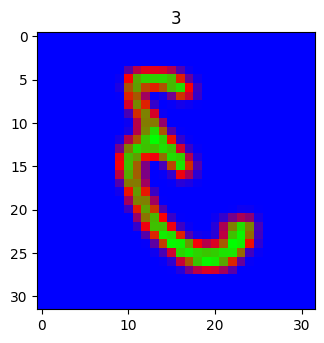

In [116]:
rand_train_idx = np.random.randint(0, len(train_inp))
show_image(train_inp[rand_train_idx], train_out[rand_train_idx].item(), cmap='brg')

In [91]:
def show_batch(images: Tensor, predictions: Tensor = None, labels: Tensor = None, columns=8, size: tuple[int, int] = None, cmap='binary'):
    if size is None:
        size = (720, 1080)
    if images.ndim == 4:
        images = images.permute(0, 2, 3, 1)
    elif images == 3:
        pass
    else:
        raise ValueError(f"Unsupported ndim")

    images = images.cpu()
    rows = math.ceil(len(images) / columns)
    fig, axes = plt.subplots(rows, columns, figsize=(size[1]*0.01, size[0]*0.01))
    if isinstance(axes, CPUArray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for index, (axis, image) in enumerate(zip(axes, images)):
        axis.imshow(image, cmap=cmap)
        title = ''
        if predictions is not None:
            title += f"P={predictions[index].cpu().item()}"
        if labels is not None:
            title += f"L={labels[index].cpu().item()}"
        if len(title) > 0:
            axis.set_title(title)
    plt.show()

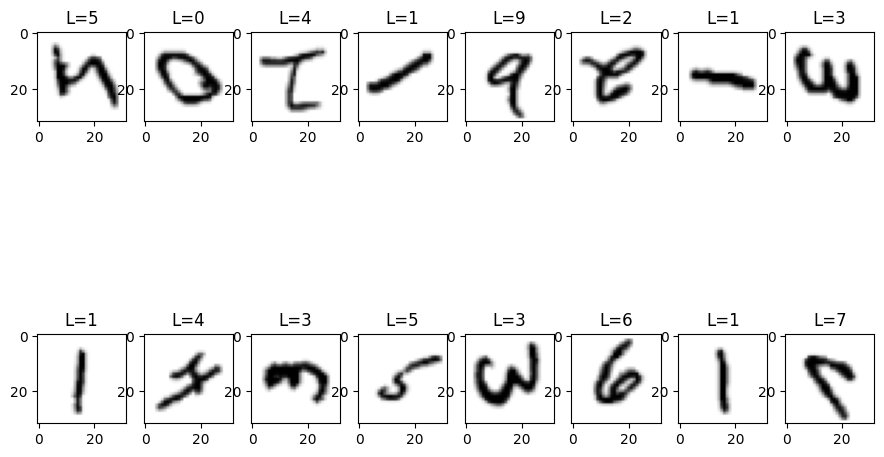

In [92]:
show_batch(train_inp[:16], labels=train_out[:16],)

# Model Architecture

In [132]:
class ResidualLayer2D(nn.Module):
    def __init__(self, inputs: int, embed_size: int, outputs: int, kernel_size: int,
                 stride=1, padding=0, padding_mode='circular',
                 activation=nn.ReLU(), bias=False, device='cpu', dtype=torch.float32):
        super(ResidualLayer2D, self).__init__()

        # Build
        self.inp_proj = nn.Conv2d(inputs, embed_size, kernel_size, stride=stride,
                                  padding=padding, padding_mode=padding_mode,
                                  device=device, dtype=dtype)
        self.mul_proj = nn.Conv2d(inputs, embed_size, kernel_size, stride=stride,
                                  padding=padding, padding_mode=padding_mode,
                                  device=device, dtype=dtype)
        self.activation = activation
        self.out_proj = nn.Conv2d(embed_size, outputs, kernel_size, stride=1,
                                  padding=padding, padding_mode=padding_mode,
                                  device=device, dtype=dtype)
        self.res_proj = nn.Conv2d(inputs, outputs, 1, stride=stride,
                                  device=device, dtype=dtype) \
            if stride > 1 or inputs != outputs else None

        # Attributes
        self.inputs     = inputs
        self.embed_size = embed_size
        self.outputs    = outputs
        self.kernel_size = kernel_size
        self.stride     = stride
        self.padding    = padding
        self.padding_mode = padding_mode
        self.bias       = bias

        # States
        self.device: torch.device = device
        self.dtype: torch.dtype = dtype

    def forward(self, tensor: Tensor):
        residual = tensor if self.res_proj is None else self.res_proj(tensor)
        swish = self.activation(self.inp_proj(tensor))
        convolution = self.out_proj(swish * self.mul_proj(tensor))
        # convolution = self.out_proj(self.activation(self.inp_proj(tensor)))
        return convolution + residual

class ResidualDepth2D(nn.ModuleList):
    def __init__(self, inputs: int, embed_size: int, outputs: int, kernel_size: int,
                 layers: int, stride=1, padding=0, padding_mode='circular', dropout: float = None,
                 activation=nn.SiLU(), bias=False, device='cpu', dtype=torch.float32):
        super(ResidualDepth2D, self).__init__()
        assert layers >= 1
        if dropout is None:
            dropout = 0

        # Build
        self.layers = nn.ModuleList([
            ResidualLayer2D(
                inputs if layer_idx == 0 else embed_size, embed_size,
                outputs if layer_idx == layers-1 else embed_size, kernel_size,
                stride if layer_idx == 0 else 1, padding if layer_idx == 0 else 1,
                padding_mode, activation, bias, device, dtype
            ) for layer_idx in range(layers)
        ])
        self.dropout = nn.Dropout(dropout)

        # Attributes
        self.inputs     = inputs
        self.embed_size = embed_size
        self.outputs    = outputs
        self.layer_num  = layers
        self.kernel_size = kernel_size
        self.stride     = stride
        self.padding    = padding
        self.padding_mode = padding_mode
        self.bias       = bias

        # States
        self.device: torch.device = device
        self.dtype: torch.dtype = dtype

    def forward(self, tensor: Tensor):
        for layer in self.layers:
            tensor = self.dropout(layer(tensor))
            # print(tensor.shape)
        return tensor

class ResidualStream2D(nn.Module):
    def __init__(self, inputs: int, embed_size: int, outputs: int, kernel_size: int,
                 depth: Union[tuple[int, int], list[int]], stride=1,
                 padding=0, padding_mode='circular', dropout: float = None,
                 activation=nn.SiLU(), bias=False, device='cpu', dtype=torch.float32):
        super(ResidualStream2D, self).__init__()
        if isinstance(depth, tuple):
            assert len(depth) == 2
            depth, length = depth
            depth = [length for _ in range(depth)]

        # Build
        self.depths = nn.ModuleList([
            ResidualDepth2D(
                inputs if depth_idx == 0 else embed_size*(stride**(depth_idx-1)),
                embed_size if depth_idx == 0 else embed_size*(stride**depth_idx),
                outputs if depth_idx == len(depth)-1 else embed_size*(stride**depth_idx),
                kernel_size, layer_size,
                stride if depth_idx != 0 else 1, padding,
                padding_mode, dropout, activation, bias,
                device, dtype
            ) for depth_idx, layer_size in enumerate(depth)
        ])

        # Attributes
        self.inputs     = inputs
        self.embed_size = embed_size
        self.outputs    = outputs
        self.depth_num  = depth
        self.kernel_size = kernel_size
        self.stride     = stride
        self.padding    = padding
        self.padding_mode = padding_mode
        self.bias       = bias

        # States
        self.device: torch.device = device
        self.dtype: torch.dtype = dtype

    def forward(self, tensor: Tensor):
        for depth in self.depths:
            tensor = depth(tensor)
        return tensor

class ResNet(nn.Module):
    def __init__(self, inputs: int, embed_size: int, outputs: int, kernel_size: int,
                 depth: Union[tuple[int, int], list[int]], kernel_size_init: int = None, fc_size=1024,
                 stride=1, padding=0, padding_mode='circular', dropout: float = None,
                 bias=False, device='cpu', dtype=torch.float32, **options):
        super(ResNet, self).__init__()
        self.pri_actv = manage_params(options, 'pri_actv', nn.ReLU())
        self.sec_actv = manage_params(options, 'sec_actv', None)

        if kernel_size_init is None:
            kernel_size_init = kernel_size
        if dropout is None:
            dropout = 0.
        if isinstance(depth, tuple):
            assert len(depth) == 2
            depth, length = depth
            depth = [length for _ in range(depth)]

        # Build
        self.encode = nn.Conv2d(
            inputs, embed_size, kernel_size_init,  stride=stride,
            padding=kernel_size_init // stride, padding_mode=padding_mode,
            bias=bias, device=device, dtype=dtype
        )
        self.init_pool = nn.MaxPool2d(kernel_size, stride=1, padding=1)
        self.stream = ResidualStream2D(
            embed_size, embed_size, embed_size*stride**(len(depth)-1), kernel_size, depth,
            stride, padding, padding_mode, dropout, self.pri_actv, bias, device, dtype
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(fc_size)
        self.decode = nn.Linear(fc_size, outputs, bias=bias, device=device, dtype=dtype)
        self.dropout = nn.Dropout(dropout)

        # Attributes
        self.inputs     = inputs
        self.embed_size = embed_size
        self.outputs    = outputs
        self.depth_num  = depth
        self.kernel_size = kernel_size
        self.stride     = stride
        self.padding    = padding
        self.padding_mode = padding_mode
        self.bias       = bias

        # States
        self.device: torch.device = device
        self.dtype: torch.dtype = dtype

    def forward(self, tensor: Tensor):
        # tensor = self.transform(tensor).unsqueeze(-3).permute(0, 1, -1, -2)
        # print(0, tensor.shape)
        tensor = self.pri_actv(self.encode(tensor))
        # print(1, tensor.shape)
        tensor = self.dropout(self.init_pool(tensor))
        # print(2, tensor.shape)
        tensor = self.stream(tensor)
        # print(3, tensor.shape)
        tensor = tensor.flatten(-3, -1)
        # print(4, tensor.shape)
        tensor = self.decode(self.dropout(self.avg_pool(tensor)))
        # print(5, tensor.shape)
        if self.sec_actv is not None:
            tensor = self.sec_actv(tensor)
        return tensor

    def get_policy(self, tensor: Tensor):
        return self.forward(tensor)

    def evaluate(self, tensor: Tensor):
        return torch.argmax(self.forward(tensor), dim=-1)

In [133]:
test_inputs = torch.randn(3, 1, 64, 64)
test_model = ResNet(
    1, 16, 10, kernel_size=3,
    depth=(3, 1), kernel_size_init=3, stride=2,
    padding=1, padding_mode='circular',
    dropout=0., pri_actv=nn.SiLU(), bias=False
)
print(test_model)
with torch.no_grad():
    test_outputs = test_model.evaluate(test_inputs)
test_outputs, test_outputs.shape

ResNet(
  (pri_actv): SiLU()
  (encode): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=circular)
  (init_pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (stream): ResidualStream2D(
    (depths): ModuleList(
      (0): ResidualDepth2D(
        (0): ModuleList(
          (0): ResidualLayer2D(
            (inp_proj): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
            (mul_proj): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
            (activation): SiLU()
            (out_proj): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          )
        )
        (1): Dropout(p=0.0, inplace=False)
      )
      (1): ResidualDepth2D(
        (0): ModuleList(
          (0): ResidualLayer2D(
            (inp_proj): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_

(tensor([6, 6, 6]), torch.Size([3]))

# Create Model

In [134]:
def model_size(model: nn.Module):
    return np.sum([param.numel() * param.element_size() for param in model.parameters()]) / (1024 ** 2)

def model_params(model: nn.Module):
    return np.sum([param.numel() for param in model.parameters()])

In [135]:
INPUT_DIMS = 1
OUTPUT_DIMS = 10
DIM_SIZE = 32
DEPTH = 3
LAYERS = 1
BIAS = False

In [136]:
MODEL = ResNet(
    1, DIM_SIZE, 10, kernel_size=3, depth=(DEPTH, LAYERS),
    kernel_size_init=7, stride=2, padding=1, padding_mode='circular', fc_size=1024,
    dropout=0.0, pri_actv=nn.SiLU(), sec_actv=None, bias=BIAS, device=DEVICE, dtype=DTYPE
)
MODEL

ResNet(
  (pri_actv): SiLU()
  (encode): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False, padding_mode=circular)
  (init_pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (stream): ResidualStream2D(
    (depths): ModuleList(
      (0): ResidualDepth2D(
        (0): ModuleList(
          (0): ResidualLayer2D(
            (inp_proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
            (mul_proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
            (activation): SiLU()
            (out_proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          )
        )
        (1): Dropout(p=0.0, inplace=False)
      )
      (1): ResidualDepth2D(
        (0): ModuleList(
          (0): ResidualLayer2D(
            (inp_proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_

In [137]:
f"{model_size(MODEL):.3f}", f"{model_params(MODEL):.2e}"

('1.599', '4.19e+05')

In [138]:
OPTIMIZER = optim.AdamW(MODEL.parameters(), lr=3e-4, weight_decay=0)

In [139]:
with torch.no_grad():
    filename = f'model_params-{MODEL.__class__.__name__}-{INPUT_DIMS}-{OUTPUT_DIMS}-{DIM_SIZE}-{DEPTH}-{LAYERS}-{BIAS}'
    # model_params = deepcopy(MODEL.state_dict())
    # save(model_params, filename, 'create_test', file_no=None)
    # del model_params
    pass

In [140]:
with torch.no_grad():
    # model_params = load(filename, 'create_test', file_no=None)
    # if model_params is not None:
    #     MODEL.load_state_dict(deepcopy(model_params))
    # del model_params
    pass

# Train

In [141]:
def get_batches(records: int, batch_size: int = None, shuffle=False):
    if batch_size is None:
        batch_size = records
    assert records > 0
    if batch_size is None:
        batch_size = records
    else:
        assert batch_size > 0
        batch_size = min(batch_size, records)

    indices: list[int] = list(range(records))
    if shuffle:
        random.shuffle(indices)
    batch_indices: list[list[int]] = list()
    batch: list[int] = list()
    for i, index in enumerate(indices):
        batch.append(index)
        batch_is_filled = len(batch) == batch_size
        no_more_records = i == len(indices) - 1 and not batch_is_filled
        if batch_is_filled or no_more_records:
            batch_indices.append(batch)
            batch = list()

    return batch_indices

In [142]:
def get_accuracy(model: nn.Module, inputs, outputs, batch_size: int):
    torch.cuda.empty_cache()
    batch_indices = get_batches(inputs.shape[0], batch_size, True)
    summation = 0
    elements = 0
    for batch in batch_indices:
        with torch.no_grad():
            target: Tensor = outputs[batch]
            prediction: torch.Tensor = model.evaluate(inputs[batch])
            total = prediction == target
            summation += 0 if target.numel() == 0 else total.float().sum().item()
            elements += target.numel()
    accuracy = np.mean(summation / elements)
    return np.round(accuracy, 4)

In [143]:
get_accuracy(MODEL, train_inp, train_out, 64), get_accuracy(MODEL, eval_inp, eval_out, 64)

(0.1091, 0.1206)

In [144]:
def train(model: nn.Module, optimizer: Optimizer, epochs: int, batch_size: int, show: tuple[int, int] = True,
          checkpoints=1, acc_step: int = None, save_best=False, clip: float = None, max_div: float = None):
    torch.cuda.empty_cache()

    batch_indices_train = get_batches(train_out.shape[0], batch_size)
    batch_indices_eval = get_batches(eval_out.shape[0], batch_size)
    losses_train = []
    losses_eval = []
    train_accuracies = []
    eval_accuracies = []
    ts, ud, ut = clock.perf_counter(), 0, epochs * len(batch_indices_train)

    best_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_eval in batch_indices_eval:
            best_loss += F.cross_entropy(model(eval_inp[batch_eval]), eval_out[batch_eval])
        if acc_step is not None:
            ta = get_accuracy(model, train_inp, train_out, batch_size)
            ea = get_accuracy(model, eval_inp, eval_out, batch_size)
            train_accuracies.append(ta)
            eval_accuracies.append(ea)
        optimizer.zero_grad()
    best_loss /= len(batch_indices_eval)
    prev_loss = best_loss

    best_epoch = -1
    model.train()
    save_state = deepcopy(model.state_dict())
    for epoch in range(epochs):
        try:
            model.train()
            train_loss = 0
            for batch_idx, batch_train in enumerate(batch_indices_train):
                loss = F.cross_entropy(model(train_inp[batch_train]), train_out[batch_train])
                loss.backward()
                if clip is not None:
                    clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                optimizer.zero_grad()

                train_loss += loss

                ud += 1
                eta(ts, ud, ut, f"training | loss={prev_loss.cpu().item(): .4e} | "
                                f"best={best_loss.cpu().item(): .4e} | "
                                f"step={best_epoch}")
            train_loss / len(batch_indices_train)

            model.eval()
            eval_loss = 0
            with torch.no_grad():
                for batch_idx, batch_eval in enumerate(batch_indices_eval):
                    loss = F.cross_entropy(model(eval_inp[batch_eval]), eval_out[batch_eval])
                    eval_loss += loss
            eval_loss /= len(batch_indices_eval)
            prev_loss = eval_loss

            if epoch % checkpoints == 0 and eval_loss < best_loss:
                best_loss = eval_loss
                save_state = deepcopy(model.state_dict())
                best_epoch = epoch

            losses_train.append(train_loss.cpu().item())
            losses_eval.append(eval_loss.cpu().item())

            if acc_step is not None and (epoch+1) % acc_step == 0:
                with torch.no_grad():
                    ta = get_accuracy(model, train_inp, train_out, batch_size)
                    ea = get_accuracy(model, eval_inp, eval_out, batch_size)
                    train_accuracies.append(ta)
                    eval_accuracies.append(ea)
                    if max_div is not None and ta > ea+max_div:
                        break
        except KeyboardInterrupt:
            break

    if save_best:
        model.load_state_dict(save_state)
    print(f"\nFinished training in {round(clock.perf_counter()-ts)}s")

    if show is None or show is True:
        show = (1440, 480)
    elif show is False:
        show = None
    if show is not None:
        fig, axes = plt.subplots(1, 2 if acc_step else 1, figsize=[s*0.01 for s in show])
        if isinstance(axes, CPUArray):
            axes = axes.flatten()
        else:
            axes = [axes]
        axes[0].plot(np.log10(losses_train), label='train')
        axes[0].plot(np.log10(losses_eval), label='eval')
        axes[0].set_title(f"Loss")
        axes[0].legend()
        if acc_step is not None:
            axes[1].plot(train_accuracies)
            axes[1].plot(eval_accuracies)
            axes[1].set_title(f'Accuracy')
        plt.show()

    model.eval()
    torch.cuda.empty_cache()

training | loss= 8.6230e-01 | best= 2.5624e-01 | step=7 | 100% | eta=0s |    
Finished training in 587s


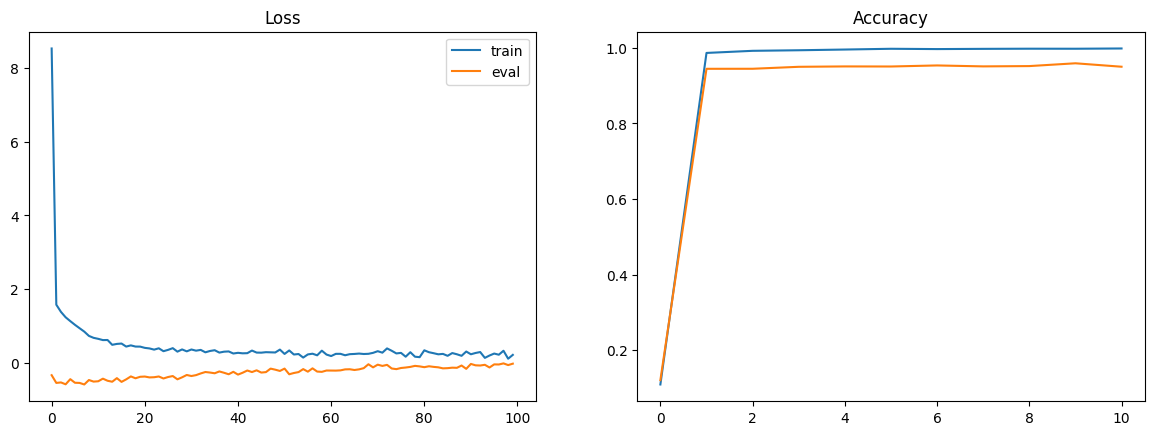

In [145]:
train(MODEL, OPTIMIZER, 100, 512, acc_step=10, clip=0.5)

In [146]:
# train(MODEL, OPTIMIZER, 100, 128, acc_step=10, clip=0.5)

In [147]:
get_accuracy(MODEL, train_inp, train_out, 64), get_accuracy(MODEL, eval_inp, eval_out, 64)

(0.9984, 0.9501)

# Evaluate

In [148]:
def get_indices(labels: Tensor, include: Union[int, list[int]] = None, shuffle=True):
    if isinstance(include, (int, float)):
        include = [include]
    indices_filtered = []
    for x, record in enumerate(labels.cpu().tolist()):
        if include is None or record in include:
            indices_filtered.append(x)
    if shuffle:
        random.shuffle(indices_filtered)
    return  indices_filtered

In [149]:
test_records = 24

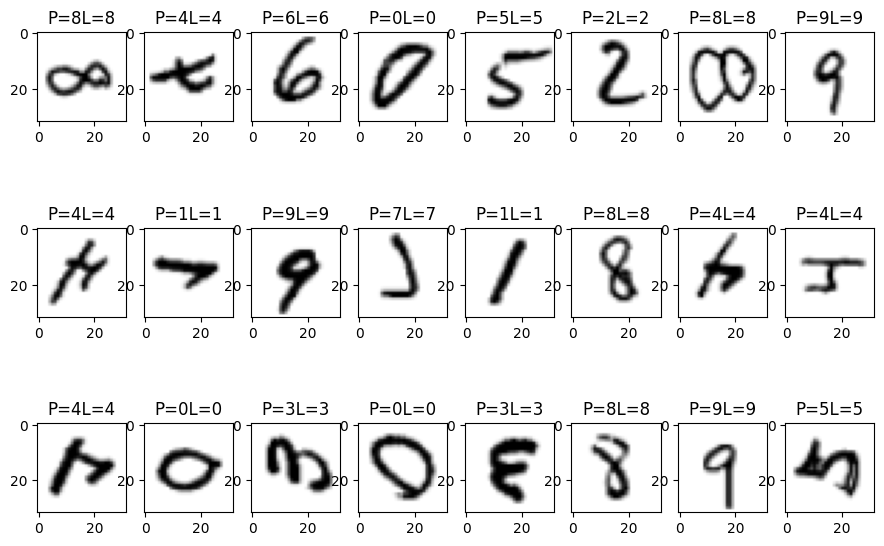

In [150]:
test_indices = get_indices(train_out)[:test_records]
test_labels = MODEL.evaluate(train_inp[test_indices])
show_batch(train_inp[test_indices], test_labels, train_out[test_indices])

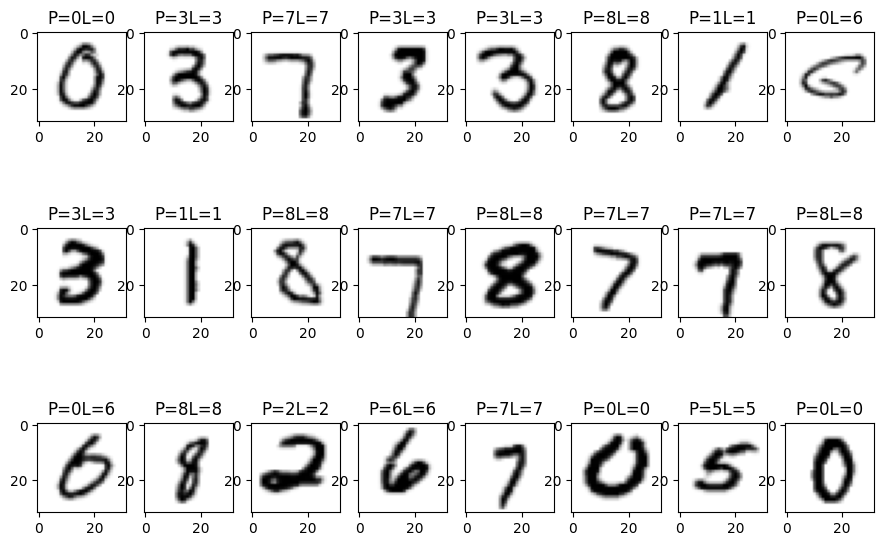

In [164]:
test_indices = get_indices(eval_out)[:test_records]
test_labels = MODEL.evaluate(eval_inp[test_indices])
show_batch(eval_inp[test_indices], test_labels, eval_out[test_indices])